In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import AMM_sim_functions as sim

import pickle
from scipy.interpolate import interp1d

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Load historical prices

currency_pair = 'ETHUSDC'
month = '2024-05'

df = pd.read_csv('data/ETHUSDC/'+currency_pair+'-1m-'+month+'.csv')
df.columns=['time', 'open', 'high', 'low', 'close', 's1', 's2', 's3', 's4', 's5', 's6', 's7']
df.set_index('time', inplace=True)
df.index = pd.to_datetime(df.index, unit='ms')

df_price = df[['close']].copy()

In [3]:
# Market Parameters

T = 31 # Time horizon
N = len(df_price)-1 # Number of periods
dt = T/N # Time increment
buy_rate = 1000.0 # Purchase rate per unit time for systematic buyers
sell_rate = 1000.0 # Sale rate per unit time for systematic sellers
buy = buy_rate*dt # Constant trade size for systematic buyers
sell = -sell_rate*dt # Constant trade size for systematic sellers
eta0 = 0.005 # CEX proportional cost
X = 30000000 # Initial CPMM Dollar Reserves
Y = X/df_price.values[0] # Initial CPMM Asset Reserves
S = X/Y # Initial CEX Price
mu = 0.0  # Mean of CEX price shock
sigma_0 = 0.03 # Initial volatility
M = 1 # Total number of sims
time = np.array([i * dt for i in range(N+1)]) # Time grid

In [4]:
# Define fee function

filename = f"../data/optimal_fees_eta0_{eta0}_mu_{mu}_buy_{round(buy_rate)}_sell_{round(sell_rate)}.pkl"

with open(filename, "rb") as f:
    vols, fees = pickle.load(f)

eta1_func = interp1d(vols, fees, kind='linear', 
                        bounds_error=False, 
                        fill_value=(fees[0], fees[-1]))

# Set constant fee

eta1 = eta1_func(sigma_0) 

In [5]:
# Run Simulation

S0 = np.vstack([df_price['close'].values]*M).T # Initialize price series

filtr_bfs , filtr_sfs =  sim.generate_trade_filters(N, M) # Generate buyer-first/seller-first trade filter

X_reserves, Y_reserves, ref_price, amm_price, buy_rev, sell_rev, arb_rev, hedge_val= \
                        sim.simulation(M, N, T, dt, buy, sell, eta0, eta1, S0, X, Y, filtr_bfs, filtr_sfs) # Market simulation

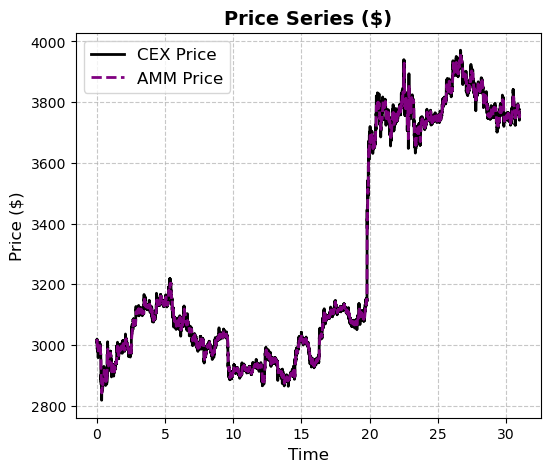

In [6]:
# Plot CEX price and AMM price
plt.figure(figsize=(6, 5)) # Set figure size
plt.plot(time, ref_price, color="black", linestyle="-", linewidth=2, label="CEX Price") 
plt.plot(time, amm_price, color="purple", linestyle="--", linewidth=2, label="AMM Price") 

# Title and labels
plt.title("Price Series ($)", fontsize=14, fontweight='bold')
plt.xlabel("Time", fontsize=12)
plt.ylabel("Price ($)", fontsize=12)

# Legend
plt.legend(loc="best", fontsize=12)

# Grid
plt.grid(True, linestyle="--", alpha=0.7)

# Show plot
plt.show()


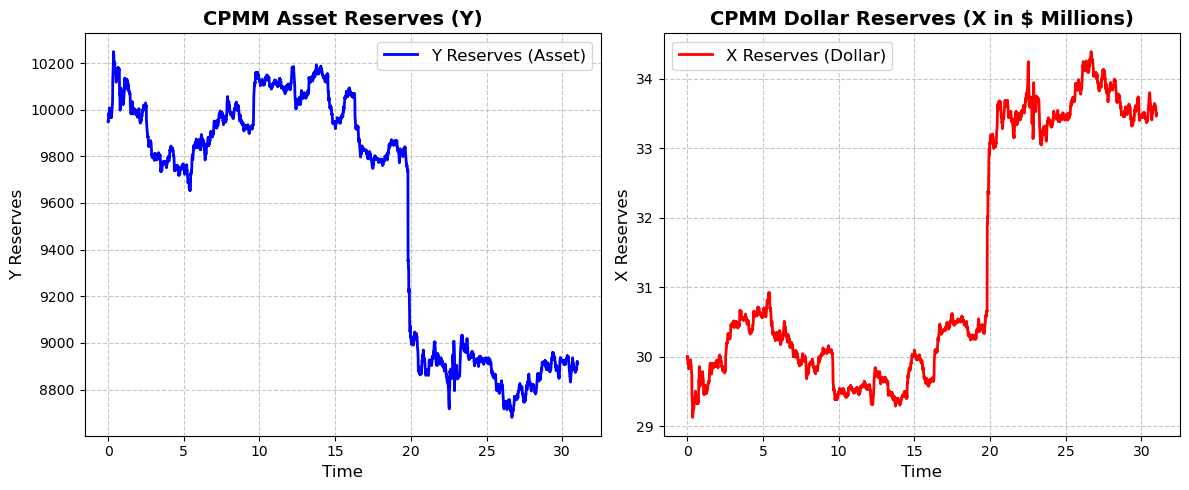

In [7]:
# Create a figure with two subplots (one for Y_reserves, one for X_reserves)
plt.figure(figsize=(12, 5))

# Plot Y reserves (asset reserves)
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st plot
plt.plot(time, Y_reserves, color="blue", linestyle="-", linewidth=2, label="Y Reserves (Asset)")
plt.title("CPMM Asset Reserves (Y)", fontsize=14, fontweight='bold')
plt.xlabel("Time", fontsize=12)
plt.ylabel("Y Reserves", fontsize=12)
plt.legend(loc="best", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)

# Plot X reserves (dollar reserves)
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd plot
plt.plot(time, X_reserves/1000000, color="red", linestyle="-", linewidth=2, label="X Reserves (Dollar)")
plt.title("CPMM Dollar Reserves (X in $ Millions)", fontsize=14, fontweight='bold')
plt.xlabel("Time", fontsize=12)
plt.ylabel("X Reserves", fontsize=12)
plt.legend(loc="best", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


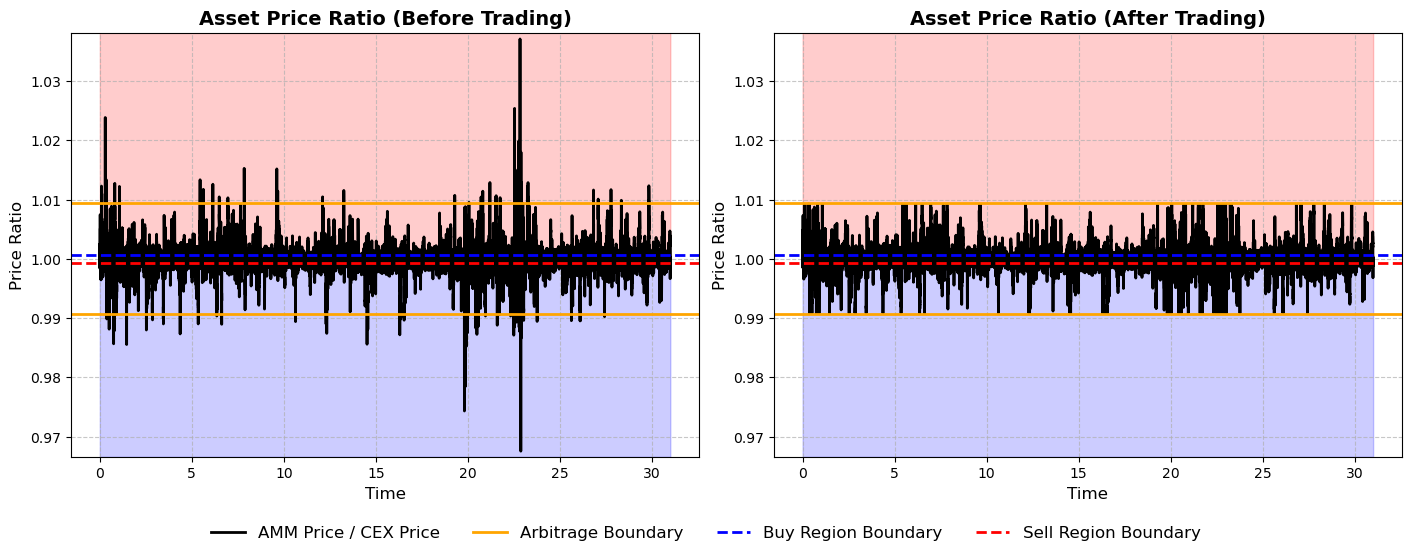

In [8]:
import matplotlib.pyplot as plt

# Compute the min and max values for consistent y-axis limits
y_min = min((amm_price[:-1] / ref_price[1:]).min(), (amm_price / ref_price).min(),
            (1 - eta1) / (1 + eta0), (1 - eta0) / (1 + eta1)) * 0.999  # Add a small margin
y_max = max((amm_price[:-1] / ref_price[1:]).max(), (amm_price / ref_price).max(),
            (1 - eta1) / (1 + eta0), (1 + eta0) / (1 - eta1)) * 1.001  # Add a small margin

# Define trader decision bounds for shading
lower_blue_bound = (1 + eta0) / (1 + eta1)  # Buy region
upper_red_bound = (1 - eta0) / (1 - eta1)  # Sell region

# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)

# ---- First Plot: Original Price Ratio ----
ax[0].plot(time[:-1], amm_price[:-1] / ref_price[1:], color="black", linestyle="-", linewidth=2, label="AMM Price / CEX Price")

# Add arbitrage bounds as horizontal lines
ax[0].axhline(y=(1 - eta1) / (1 + eta0), color='orange', linestyle='-', linewidth=2, label="Arbitrage Boundary")
ax[0].axhline(y=(1 + eta0) / (1 - eta1), color='orange', linestyle='-', linewidth=2)
ax[0].axhline(y=lower_blue_bound, color='b', linestyle='--', linewidth=2, label="Buy Region Boundary")
ax[0].axhline(y=upper_red_bound, color='r', linestyle='--', linewidth=2, label="Sell Region Boundary")

# Add shaded regions
ax[0].fill_between(time[:-1], y_min, lower_blue_bound, color='blue', alpha=0.2)  # Blue below lower bound (buy region)
ax[0].fill_between(time[:-1], upper_red_bound, y_max, color='red', alpha=0.2)   # Red above upper bound (sell region)

# Labels and formatting
ax[0].set_title("Asset Price Ratio (Before Trading)", fontsize=14, fontweight='bold')
ax[0].set_xlabel("Time", fontsize=12)
ax[0].set_ylabel("Price Ratio", fontsize=12)
ax[0].grid(True, linestyle="--", alpha=0.7)
ax[0].set_ylim(y_min, y_max) 

# ---- Second Plot: Price Ratio After Trading ----
ax[1].plot(time, amm_price / ref_price, color="black", linestyle="-", linewidth=2, label="")

# Add arbitrage bounds as horizontal lines
ax[1].axhline(y=(1 - eta1) / (1 + eta0), color='orange', linestyle='-', linewidth=2, label="")
ax[1].axhline(y=(1 + eta0) / (1 - eta1), color='orange', linestyle='-', linewidth=2)
ax[1].axhline(y=lower_blue_bound, color='b', linestyle='--', linewidth=2, label="")
ax[1].axhline(y=upper_red_bound, color='r', linestyle='--', linewidth=2, label="")

# Add shaded regions
ax[1].fill_between(time, y_min, lower_blue_bound, color='blue', alpha=0.2)  # Blue below lower bound (buy region)
ax[1].fill_between(time, upper_red_bound, y_max, color='red', alpha=0.2)   # Red above upper bound (sell region)

# Labels and formatting
ax[1].set_title("Asset Price Ratio (After Trading)", fontsize=14, fontweight='bold')
ax[1].set_xlabel("Time", fontsize=12)
ax[1].set_ylabel("Price Ratio", fontsize=12)
ax[1].grid(True, linestyle="--", alpha=0.7)
ax[1].set_ylim(y_min, y_max) 

# Move the legend below the plot
fig.legend(loc="lower center", bbox_to_anchor=(0.5, -0.1), fontsize=12, ncol=4, frameon=False)

# Show the figure
plt.show()


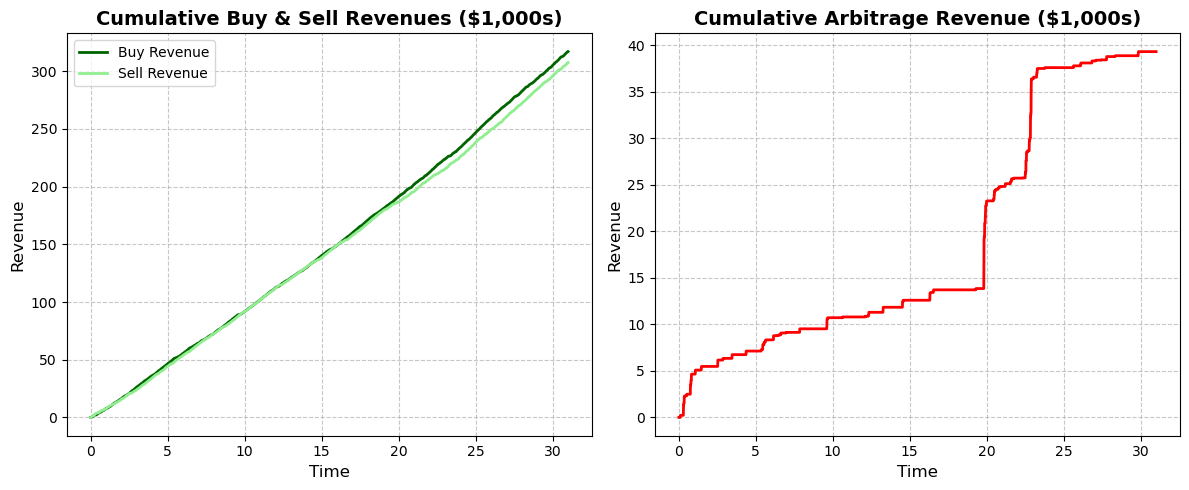

In [9]:
# Compute cumulative revenues
cumulative_buy_rev = np.cumsum(buy_rev)
cumulative_sell_rev = np.cumsum(sell_rev)
cumulative_arb_rev = np.cumsum(arb_rev)

# Create a figure with two subplots
plt.figure(figsize=(12, 5))

# ---- First Plot: Cumulative Buy and Sell Revenues ----
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st plot
plt.plot(time, cumulative_buy_rev/1000, color="darkgreen", linestyle="-", linewidth=2, label="Buy Revenue")
plt.plot(time, cumulative_sell_rev/1000, color="lightgreen", linestyle="-", linewidth=2, label="Sell Revenue")

# Labels and formatting
plt.title("Cumulative Buy & Sell Revenues ($1,000s)", fontsize=14, fontweight='bold')
plt.xlabel("Time", fontsize=12)
plt.ylabel("Revenue", fontsize=12)
plt.legend(loc="best", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.7)

# ---- Second Plot: Cumulative Arbitrage Revenue ----
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd plot
plt.plot(time, cumulative_arb_rev/1000, color="red", linestyle="-", linewidth=2, label="Arbitrage Revenue")

# Labels and formatting
plt.title("Cumulative Arbitrage Revenue ($1,000s)", fontsize=14, fontweight='bold')
plt.xlabel("Time", fontsize=12)
plt.ylabel("Revenue", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the figure
plt.show()


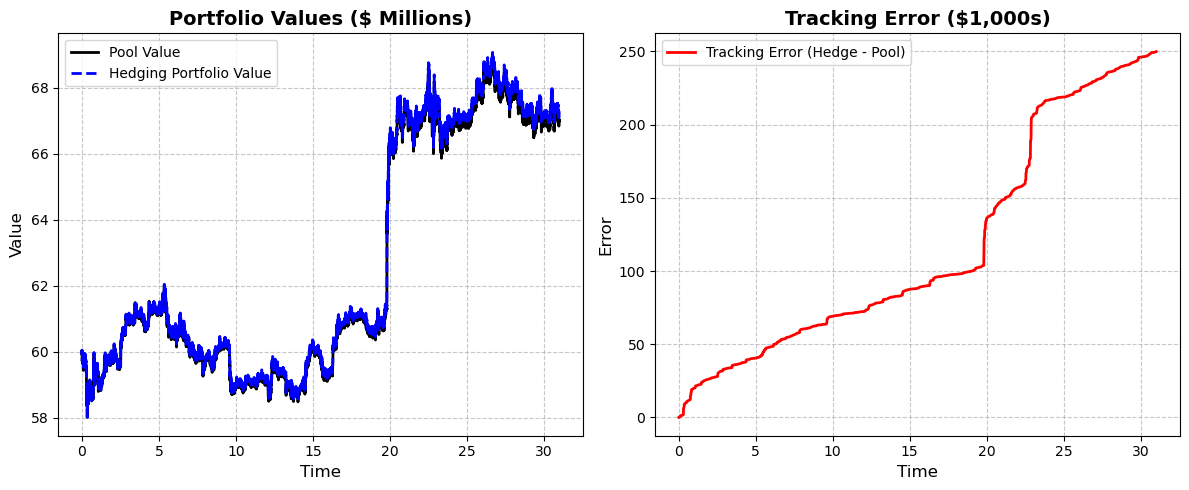

In [10]:
# Compute hedging portfolio value and tracking error
pool_value = X_reserves + Y_reserves * ref_price
hedge_err =  hedge_val - pool_value # Note: this will be non-decreasing

# Create a figure with two subplots
plt.figure(figsize=(12, 5))

# ---- First Plot: Hedging Portfolio Value ----
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st plot
plt.plot(time, pool_value/1000000, color="black", linestyle="-", linewidth=2, label="Pool Value")
plt.plot(time, hedge_val/1000000, color="blue", linestyle="--", linewidth=2, label="Hedging Portfolio Value")

# Labels and formatting
plt.title("Portfolio Values ($ Millions)", fontsize=14, fontweight='bold')
plt.xlabel("Time", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.legend(loc="best", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.7)

# ---- Second Plot: Tracking Error ----
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd plot
plt.plot(time, hedge_err/1000, color="red", linestyle="-", linewidth=2, label="Tracking Error (Hedge - Pool)")

# Labels and formatting
plt.title("Tracking Error ($1,000s)", fontsize=14, fontweight='bold')
plt.xlabel("Time", fontsize=12)
plt.ylabel("Error", fontsize=12)
plt.legend(loc="best", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.7)

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the figure
plt.show()


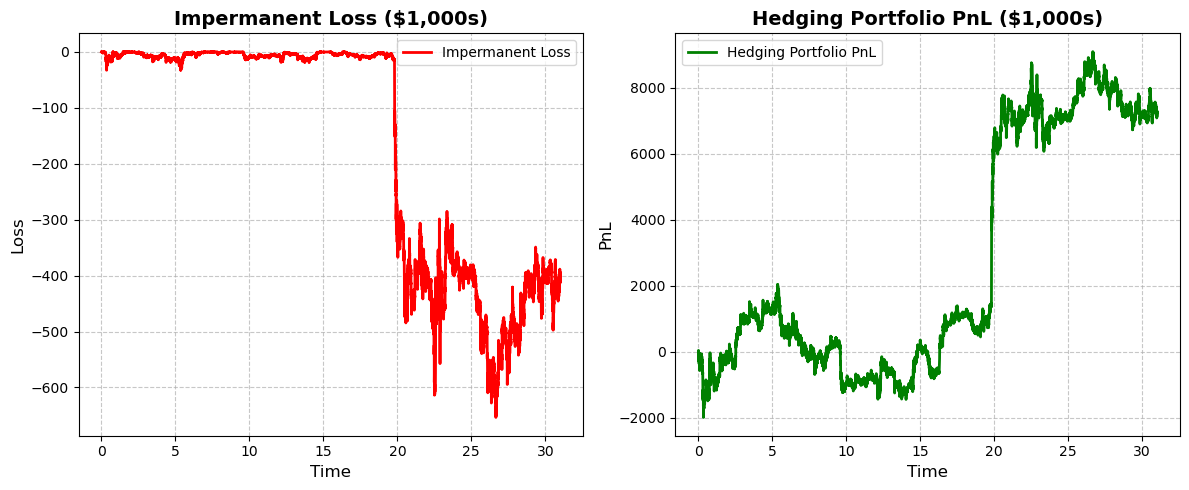

In [11]:
# Compute impermanent loss and hedging portfolio PnL
imp_loss = X_reserves + Y_reserves * ref_price - X_reserves[0] - Y_reserves[0] * ref_price
hedge_pnl = hedge_val - pool_value[0]

# Create a figure with two subplots
plt.figure(figsize=(12, 5))

# ---- First Plot: Impermanent Loss ----
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st plot
plt.plot(time, imp_loss/1000, color="red", linestyle="-", linewidth=2, label="Impermanent Loss")

# Labels and formatting
plt.title("Impermanent Loss ($1,000s)", fontsize=14, fontweight='bold')
plt.xlabel("Time", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend(loc="best", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.7)

# ---- Second Plot: Hedging Portfolio PnL ----
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd plot
plt.plot(time, hedge_pnl/1000, color="green", linestyle="-", linewidth=2, label="Hedging Portfolio PnL")

# Labels and formatting
plt.title("Hedging Portfolio PnL ($1,000s)", fontsize=14, fontweight='bold')
plt.xlabel("Time", fontsize=12)
plt.ylabel("PnL", fontsize=12)
plt.legend(loc="best", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.7)

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the figure
plt.show()


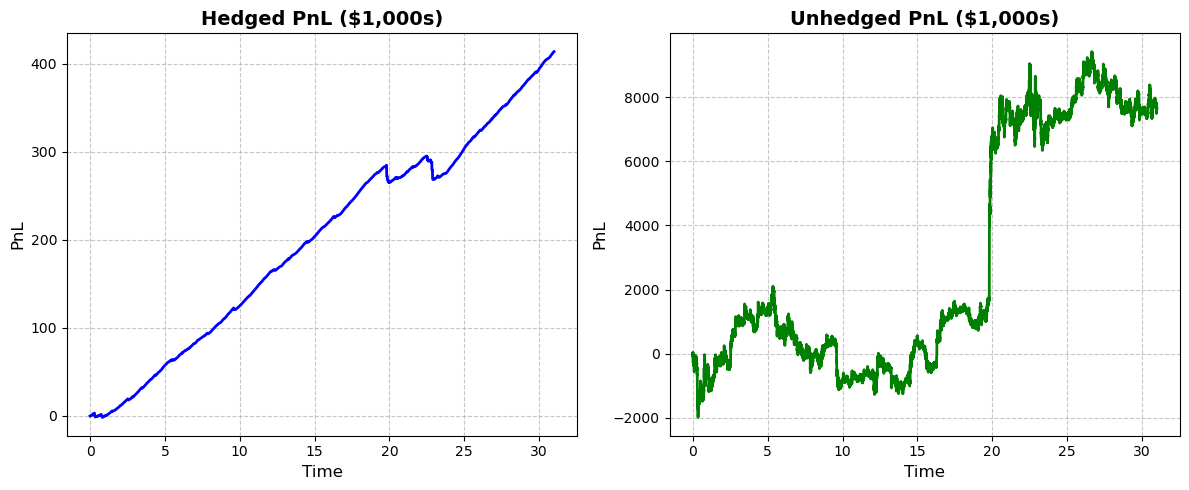

In [12]:
# Compute cumulative PnL for hedged and unhedged cases
pnl_hedged = np.cumsum(buy_rev + sell_rev + arb_rev) - hedge_err.squeeze()
pnl_unhedged = np.cumsum(buy_rev + sell_rev + arb_rev) + pool_value.squeeze() - pool_value[0][0]

# Create a figure with two subplots
plt.figure(figsize=(12, 5))

# ---- First Plot: Hedged PnL ----
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st plot
plt.plot(time, pnl_hedged/1000, color="blue", linestyle="-", linewidth=2, label="Hedged PnL")

# Labels and formatting
plt.title("Hedged PnL ($1,000s)", fontsize=14, fontweight='bold')
plt.xlabel("Time", fontsize=12)
plt.ylabel("PnL", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)

# ---- Second Plot: Unhedged PnL ----
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd plot
plt.plot(time, pnl_unhedged/1000, color="green", linestyle="-", linewidth=2, label="Unhedged PnL")

# Labels and formatting
plt.title("Unhedged PnL ($1,000s)", fontsize=14, fontweight='bold')
plt.xlabel("Time", fontsize=12)
plt.ylabel("PnL", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the figure
plt.show()
